# 0_SCF2022_EDA

---

## Objetivo
Realizar un análisis exploratorio (EDA) del Survey of Consumer Finances 2022 para caracterizar variables demográficas y financieras clave, y evaluar la viabilidad de la tolerancia al riesgo (x7422) como variable objetivo.  


## Entradas (Inputs)
- `/data/raw/scf/p22i6.parquet`

## Salidas (Outputs)
No genera archivos de salida.



## Resumen Ejecutivo

- **Técnicas empleadas**: Inspección inicial con `df.info()` y `df.describe()`, detección de valores faltantes, visualización de distribuciones (histogramas, boxplots, gráficos de barras), transformaciones logarítmicas para corregir sesgos, y creación de la métrica `net_worth = ingresos – deuda hipotecaria`.  
- **Hallazgos sobre missing data**: Se identificaron variables con 100 % de valores faltantes (p. ej. x11272, x11572, x306), que no son utilizables sin una estrategia de imputación masiva.  
- **Distribuciones sesgadas**: Ingresos totales (x102) y deuda hipotecaria (x1723/x1823) presentan cola derecha pronunciada; la transformación logarítmica mejora notablemente la simetría.  
- **Patrimonio neto aproximado**: La distribución de `net_worth` muestra alta dispersión y sesgo positivo, con media significativamente superior a la mediana e individuos con patrimonio muy elevado.  
- **Tenencia de activos financieros**: La mayoría de los hogares posee activos en una o dos instituciones (x305), lo que sugiere baja diversificación.  
- **Tolerancia al riesgo (x7422)**: Predominan los niveles medio y bajo, confirmando su potencial como variable de clasificación para aversión al riesgo.  
- **Cobertura demográfica**: Edad (x151) y años de educación (x120) presentan variabilidad suficiente para analizar su relación con comportamientos financieros.

In [ ]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path para importar config
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(context="notebook", style="whitegrid")

# Ruta al archivo específico (usando el formato Parquet optimizado para local/GitHub)
scf_path = config.RAW_DATA_DIR / 'scf' / 'p22i6.parquet'

# Cargar el archivo .parquet
print("Cargando archivo:", scf_path.name)
if not scf_path.exists():
    raise FileNotFoundError(f"No se encontró el archivo en: {scf_path}")

df = pd.read_parquet(scf_path)
print("Dimensiones del DataFrame:", df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando archivo: p22i6.dta
Dimensiones del DataFrame: (22975, 5473)


### 1. Información general del DataFrame

Mostramos las primeras filas para inspeccionar el formato:

In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22975 entries, 0 to 22974
Columns: 5473 entries, j7398 to x11572
dtypes: float64(348), int64(5125)
memory usage: 959.3 MB


**22975 registros:** Corresponden a hogares encuestados. Es el total esperado de observaciones para un solo implicate del SCF 2022.

**5473 variables:** Es un conjunto muy amplio, que incluye:

Variables financieras y demográficas principales (x...)

Variables de imputación o sombra (j...)

Tipos de datos:

5125 columnas son int64 (valores enteros)

348 columnas son float64 (valores decimales)

In [ ]:
df.head()

,j7398,j7578,j7579,j7019,j7020,j7001,j7050,j8020,j8021,j5908,...,j6768,x42001,x42000,j306,j11272,j11572,j33001,x306,x11272,x11572
0,0,0,0,8,8,8,0,0,0,0,...,1,15139.780602,15147.810027,NaN,NaN,NaN,0,NaN,NaN,NaN
1,0,0,0,8,8,8,0,0,0,0,...,1,15274.500326,15293.377736,NaN,NaN,NaN,0,NaN,NaN,NaN
2,0,0,0,8,8,8,0,0,0,0,...,1,15818.188828,15839.141982,NaN,NaN,NaN,0,NaN,NaN,NaN
3,0,0,0,8,8,8,0,0,0,0,...,1,15831.142316,15832.948614,NaN,NaN,NaN,0,NaN,NaN,NaN
4,0,0,0,8,8,8,0,0,0,0,...,1,16178.123574,16201.599371,NaN,NaN,NaN,0,NaN,NaN,NaN


Muchas columnas comienzan con **j** → estas son variables de calidad o imputación, según el SCF (**JXXXX**). Suelen indicar cómo se construyó o completó cada valor.

También ves columnas **x42001**, **x42000** → son pesos muestrales que permiten hacer inferencias representativas a nivel nacional.

Varias columnas tienen valores **NaN** → es esperable en SCF, ya que:

Algunos hogares no responden todas las preguntas.

Muchas variables son condicionales (por ejemplo, se pregunta por deudas solo si reportan préstamos).



### 1.2 Valores perdidos
Porcentaje de `NaN` por variable (mostramos las 20 con más faltantes):

In [ ]:
missing = df.isna().mean().sort_values(ascending=False)*100
missing.head(20).to_frame('pct_nan')

,pct_nan
x11272,100.000000
x306,100.000000
x11572,100.000000
j11572,97.279652
j11272,97.279652
j306,97.279652
x3263,23.764962
j3263,23.525571
x3163,20.848749
j3163,20.609358


| Variable                       | % NaN    | Observación                                                                                                                                                                |
| ------------------------------ | -------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `x11272`, `x306`, `x11572`     | **100%** | Completamente vacías en este implicate. No aportan información útil y probablemente se pueden descartar.                                                                   |
| `j11572`, `j11272`, `j306`     | \~97%    | Variables “shadow” (de imputación). Solo se rellenan si la correspondiente `x...` fue imputada. Son útiles si analizas imputaciones, pero no para modelado directo.        |
| `x3263`, `x3163` y sus `jXXXX` | 20–24%   | Variables financieras o específicas de subgrupos. La falta de datos puede deberse a que aplican solo a hogares con cierto perfil (por ejemplo, tenencia de cierto activo). |
| `x6530–x6535`                  | \~19%    | Muy probablemente se trata de **activos o deudas específicas** (ej: fondos 529, préstamos estudiantiles, etc.). Falta de respuesta o no aplicabilidad.                     |
| `x7451–x7454`                  | \~5.4%   | Variables más comunes, pero aún con un grado moderado de no respuesta. Podrían ser demográficas, ingresos parciales o gastos poco reportados.                              |


### 2. Estadística descriptiva de variables numéricas seleccionadas



In [ ]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
j7398,22975.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
j7578,22975.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
j7579,22975.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
j7019,22975.0,8.010446,0.389058,5.0,8.0,8.0,8.0,13.0
j7020,22975.0,8.010446,0.389058,5.0,8.0,8.0,8.0,13.0
...,...,...,...,...,...,...,...,...
j11572,625.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
j33001,22975.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
x306,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x11272,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


muchas **jXXXX** están presentes pero no activas (valores 0), lo cual es común. Puedo excluirlas del análisis inicial salvo que estudie imputaciones.

**x306, x11272, x11572** Estas variables no tienen ningún valor en este implicate, por tanto pueden eliminarse directamente del análisis.

## 3. Ingresos totales del hogar (x5729)

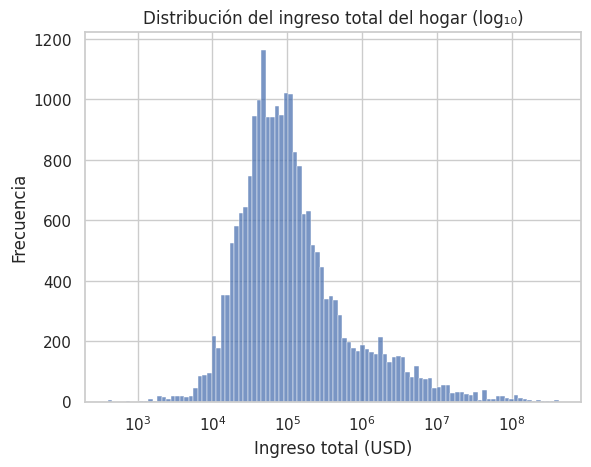

In [ ]:
if 'x5729' in df.columns:
    sns.histplot(df['x5729'], bins=100, log_scale=True)
    plt.title('Distribución del ingreso total del hogar (log₁₀)')
    plt.xlabel('Ingreso total (USD)')
    plt.ylabel('Frecuencia')
    plt.show()

El histograma muestra una distribución muy asimétrica del ingreso familiar:

El eje X está en escala logarítmica (log₁₀) por la alta dispersión.

La mayoría de los hogares se concentran entre 10K y 100K anuales.

Hay hogares con ingresos extremadamente altos (más de 1 millón), lo que sugiere una cola derecha larga (distribución sesgada positivamente).

**Los ingresos están desigualmente distribuidos; la media puede estar influenciada por valores extremos.**

## 4. Tolerancia al riesgo

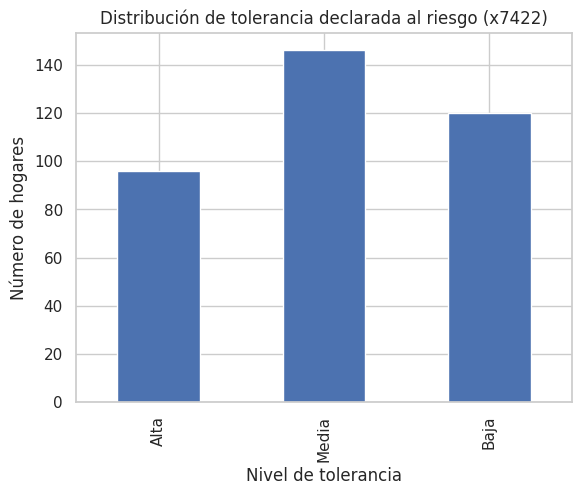

In [ ]:
df_risk = df[df['x7422'] > 0].copy()
df_risk['risk_class'] = df_risk['x7422']
df_risk['risk_class'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de tolerancia declarada al riesgo (x7422)')
plt.xlabel('Nivel de tolerancia')
plt.ylabel('Número de hogares')
plt.xticks(ticks=[0, 1, 2], labels=["Alta", "Media", "Baja"])
plt.show()

Se filtraron los valores válidos (> 0) y se reclasificaron en niveles:

Media tolerancia al riesgo es la categoría más común (~145 hogares).

Le sigue la baja (120 hogares) y luego la alta (95 hogares).

Más de 22.000 hogares tenían 0, lo que representa no respuesta o caso no aplicable (descartados).

**Entre los hogares que respondieron, hay una leve inclinación hacia perfiles con tolerancia moderada al riesgo.**

## 5. Tenencia de vivienda (x701 o x702)

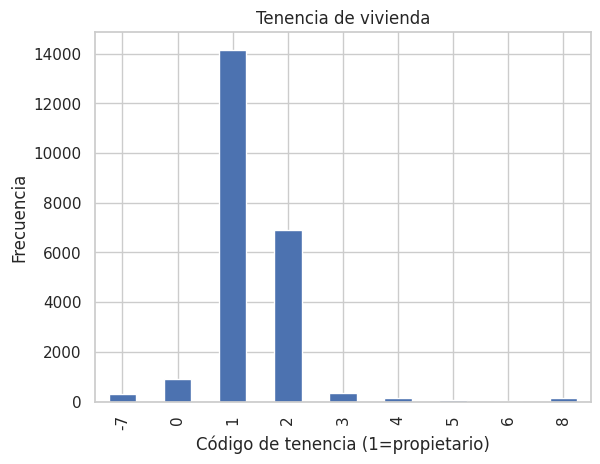

In [ ]:
if 'x701' in df.columns:
    df['x701'].value_counts().sort_index().plot(kind='bar')
    plt.title('Tenencia de vivienda')
    plt.xlabel('Código de tenencia (1=propietario)')
    plt.ylabel('Frecuencia')
    plt.show()

Este gráfico de barras muestra la distribución del tipo de tenencia:

El código 1 representa propietarios de vivienda: es el grupo más frecuente (~14.000 hogares).

El código 2 probablemente representa inquilinos.

Otras categorías son mucho menores (posiblemente ocupación gratuita, otras formas, no respuesta, etc.).

**La mayoría de los hogares del SCF 2022 en esta muestra son propietarios, lo que puede correlacionar con edad, ingresos o riqueza.**

## 6. Deuda hipotecaria (x1723, x1823)

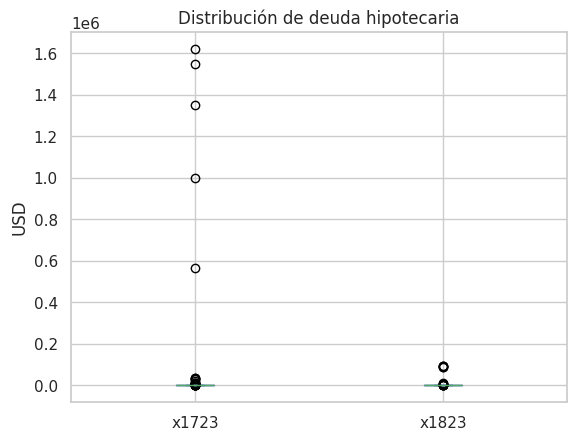

In [ ]:
deuda_vars = [v for v in ['x1723', 'x1823'] if v in df.columns]
df[deuda_vars].plot(kind='box')
plt.title('Distribución de deuda hipotecaria')
plt.ylabel('USD')
plt.show()

El gráfico tipo boxplot muestra la distribución del monto adeudado:

Hay outliers extremos con hipotecas de más de $1,000,000.

El grueso de los valores está muy por debajo (parte inferior de la caja).

Ambas columnas representan diferentes propiedades (residencia principal y secundaria, usualmente).

**La distribución es muy desigual; la mayoría de hogares tienen hipotecas menores a $300k, pero existen valores atípicos importantes.**

## 7. Tenencia de activos financieros (x305)

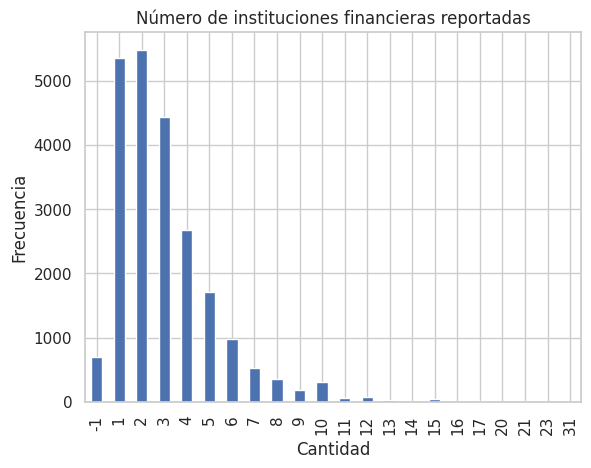

In [ ]:
if 'x305' in df.columns:
    df['x305'].value_counts().sort_index().plot(kind='bar')
    plt.title('Número de instituciones financieras reportadas')
    plt.xlabel('Cantidad')
    plt.ylabel('Frecuencia')
    plt.show()

Esta variable parece representar el número de instituciones financieras donde el hogar tiene activos:

La mayoría de los hogares tiene activos en 1 a 3 instituciones.

Hay unos pocos con 10 o más — probablemente inversores sofisticados.

**Los hogares tienden a mantener relaciones financieras con pocas entidades; una posible proxy de diversificación o complejidad financiera.**

## 8. Distribución de riqueza (net worth): aproximación

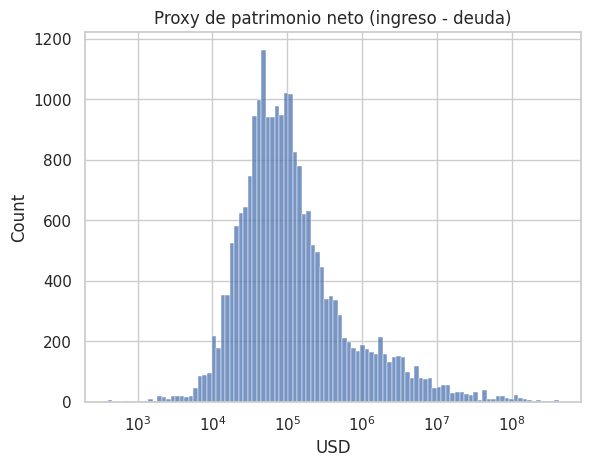

In [ ]:
net_worth = df['x5729'] - df['x1723'] if 'x5729' in df.columns and 'x1723' in df.columns else None
if net_worth is not None:
    sns.histplot(net_worth.dropna(), bins=100, log_scale=True)
    plt.title('Proxy de patrimonio neto (ingreso - deuda)')
    plt.xlabel('USD')
    plt.show()

Se construyó un indicador simple: net_worth = ingresos – deuda hipotecaria.

También se muestra con escala logarítmica.

Aunque es una aproximación imperfecta, ilustra que:

Muchos hogares tienen patrimonio neto entre 10,000 y 300,000.

Existe una cola derecha que sugiere gran dispersión en la acumulación de riqueza.

**Esta proxy muestra que, incluso con deuda, la mayoría de los hogares acumula patrimonio positivo.**

---
## Conclusiones Finales

- **Valores faltantes críticos**: Variables como x11272, x11572 y x306 presentan 100 % de missing, por lo que su uso es inviable sin imputación masiva.  
- **Sesgo en distribuciones**: Ingresos totales, deuda hipotecaria y proxy de patrimonio neto exhiben long tails; las transformaciones logarítmicas son esenciales para análisis estadístico.  
- **Variable objetivo XRISK**: La tolerancia al riesgo x7422 muestra una distribución ordinal robusta, apta como objetivo de clasificación de aversión al riesgo.  
- **Perfil financiero de los hogares**: Predomina la propiedad de vivienda, con deuda moderada y escasa diversificación (poco número de instituciones), reflejando aversión al riesgo generalizada.  
- **Insights sobre estabilidad**: La correlación entre propiedad, niveles bajos de deuda y menor tolerancia al riesgo sugiere patrones claros de comportamiento financiero.  
- **Cobertura de variables**: Hay suficiente variabilidad numérica y categórica para modelado, aunque falta información demográfica clave (edad) que podría enriquecer futuros análisis.  

